In [7]:
import pandas as pd
import numpy as np
from pandas import read_excel

from collections import Counter
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.util import ngrams
import re

In [8]:
df = pd.read_csv('46_1.csv')
display(df)

,Final,GENRE
0,১০১০ গাণিতিক কুইজ,0.0
1,১১৮ টি মৌলের ইতিবৃত্ত,0.0
2,420 গণিত,0.0
3,৫০৫ গাণিতিক কুইজ,0.0
4,৫২টি প্রোগ্রামিং সমস্যা ও সমাধান,0.0
...,...,...
4604,হরর ১৩,3.0
4605,তন্দ্রাবিলাস,3.0
4606,শ্মশানঘাট,3.0
4607,ইলিয়ানা সমগ্র,3.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4609 entries, 0 to 4608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Final   4609 non-null   object 
 1   GENRE   4608 non-null   float64
dtypes: float64(1), object(1)
memory usage: 72.1+ KB


In [10]:
df['GENRE'] = df['GENRE'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4609 entries, 0 to 4608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Final   4609 non-null   object  
 1   GENRE   4608 non-null   category
dtypes: category(1), object(1)
memory usage: 40.8+ KB


In [11]:
df.dropna(inplace=True)
df.shape

(4608, 2)

In [12]:
df.drop_duplicates(subset=["Final"],inplace=True)
df.shape

(4465, 2)

In [13]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    #punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    punctuations = '''````£|¢|Ñ+-*/=EROero৳012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [14]:
df['Final'] = df.Final.apply(lambda x: preprocessing(str(x)))
display(df)

,Final,GENRE
0,১০১০ গাণিতিক কুইজ,0.0
1,১১৮ টি মৌলের ইতিবৃত্ত,0.0
2,গণিত,0.0
3,৫০৫ গাণিতিক কুইজ,0.0
4,৫২টি প্রোগ্রামিং সমস্যা ও সমাধান,0.0
...,...,...
4603,সাতটি রহস্য গল্প,3.0
4605,তন্দ্রাবিলাস,3.0
4606,শ্মশানঘাট,3.0
4607,ইলিয়ানা সমগ্র,3.0


In [15]:
import BnLemma as lm
from collections import Counter

bl = lm.Lemmatizer()
lemmatized_words_counter = Counter()
transformation_counter = Counter()
custom_transformations = {
    "হিস্ট্রি" : "ইতিহাস",
    "ইতিহাসের" : "ইতিহাস",
    "অঙ্ক": "গণিত",
    "অঙ্কের": "গণিত",
    "গাণিতিক" : "গণিত",
    "অংকের" : "গণিত",
    "রাজ্যে": "রাজ্য",
    "চাচা": "চাচা",
    "কৈশোর" : "ছোট",
    "কৈশোরের" : "ছোট",
    "কৈশোরী" : "ছোট",
    "কৈশোরীর" : "ছোট",
    "কৈশোরদের" : "ছোট",
    "কৈশোর" : "ছোট",
    "শিশু" : "ছোট",
    "ছোট্ট" : "ছোট",
    "ছোটদার" : "ছোট",
    "শিশুর" : "ছোট",
    "শিশুদের" : "ছোট",
    "বালক" : "ছোট",
    "বালকের" : "ছোট",
    "বালিকা" : "ছোট",
    "বালিকার" : "ছোট",
    "ছোটদের" : "ছোট",
    "ছোট" : "ছোট",
    "কমিক্স" : "কমিকস",
    "গ্রাফিক" : "কমিকস",
    "কমিক্সের" : "কমিকস",
    "কমিকস" : "কমিকস",
    "কার্টুন" : "কমিকস",
    "কমিক্‌স" : "কমিকস",
    "গুড্ডুবুড়া": "কমিকস",
    "টিনটিন" : "কমিকস",
    "সিসিমপুরে": "কমিকস",
    "সিসিমপুর" : "কমিকস",
    "টিনটিনের" : "কমিকস",
    "টিনটিনে" : "কমিকস",
    "টমের " : "কমিকস",
    "জেরি" : "কমিকস",
    "টম" : "কমিকস",
    "ডোরেমন" : "কমিকস",
    "ডোরেমনের" : "কমিকস",
    "সিনডেরেলা": "কমিকস",
    "সিনডেরেলার" : "কমিকস",
    "বেসিক আলী" : "কমিকস",
    "নোমান" : "কমিকস",
    "বাবু" : "কমিকস",
    "গুবলে" : "কমিকস",
    "সিনডরেলা" : "কমিকস",
    "প্যারাহীন" : "কমিকস",
    "ডোরা" : "কমিকস",
    "স্পাইডারম্যান" : "কমিকস",
    "স্পাইডারম্যানের" : "কমিকস",
    "ডোরার" : "কমিকস",
    "জাদুকর" : "জাদু",
    "পশুপাখির" : "প্রাণি",
    "বাঘরা" : "প্রাণি",
    "ব্যাঙ" : "প্রাণি",
    "বাঘ" : "প্রাণি",
    "মাছের" : "প্রাণি",
    "শালিকছানা" : "পাখি",
    "হাঁস" : "পাখি",
    "পাখির" : "পাখি",
    "পাখি" : "পাখি",
    "পাখিদের": "পাখি",
    "ময়নাপাখি": "পাখি",
    "ময়না" : "পাখি",
    "শালিক" : "পাখি",
    "বুবলিদের" : "পাখি",
    "বুবলি" : "পাখি",
    "পিঁপড়ে" : "প্রাণি",
    "পায়রা" : "পাখি",
    "পায়রার" : "পাখি",
    "ফড়িং" : "পাখি",
    "ফড়িংর" : "পাখি",
    "প্রজাপতি" : "পাখি",
    "প্রজাপতির" : "পাখি",
    "টিয়া" : "পাখি",
    "ইঁদুর" : "প্রাণি",
    "বিড়াল" : "প্রাণি",
    "বিড়ালের" : "প্রাণি",
    "বিড়ালদের" : "প্রাণি",
    "বিড়ালেরা" : "প্রাণি",
    "কাঠবিড়ালির" : "প্রাণি",
    "নেকড়ে" : "প্রাণি",
    "নেকড়ের" : "প্রাণি",
    "বাদুড়ের" : "প্রাণি",
    "বাদুড়" : "প্রাণি",
    "কাঠবিড়াল" : "প্রাণি",
    "জলপরি" : "প্রাণি",
    "পরী" : "প্রাণি",
    "পরি" : "প্রাণি",
    "পরির" : "প্রাণি",
    "পরীর" : "প্রাণি",
    "ব্যাঙের" : "প্রাণি",
    "ব্যাঙ" : "প্রাণি",
    "হাতি": "প্রাণি",
    "হাতির": "প্রাণি",
    "তেলাপোকা": "প্রাণি",
    "মাছ": "প্রাণি",
    "সিংহ": "প্রাণি",
    "হনুমান" : "প্রাণি",
    "হনুমানের" : "প্রাণি",
    "বানর" : "প্রাণি",
    "বানরের" : "প্রাণি",
    "কুমিরের " : "প্রাণি",
    "কুমির" : "প্রাণি",
    "যাদুকরের" : "জাদু",
    "যাদুকর" : "জাদু",
    "প্রেম" : "ভালোবাসা",
    "প্রেমের" : "ভালোবাসা",
    "প্রেমে" : "ভালোবাসা",
    "প্রেমের" : "ভালোবাসা",
    "ভালোবাসা" : "ভালোবাসা",
    "ভালোবাসার" : "ভালোবাসা",
    "ভালোবাসায়" : "ভালোবাসা",
    "প্রিয়তমা" : "ভালোবাসা",
    "লাভিং" : "ভালোবাসা",
    "প্রিয়তমার" : "ভালোবাসা",
    "রচনাবলি" : "গল্প",
    "রচনাবলী " : "গল্প",
    "রচনাসমগ্র" : "গল্প",
    "হরর" : "ভয়",
    "যকের" : "ভয়",
    "ছোটগল্প" : "গল্প",
    "কাব্য" : "কবিতা",
    "জননী" : "মা",
}

def lemmatize_sentence(sentence):
    try:
        words = sentence.split() 
        lemmatized_words = []    
        for word in words:
            #lemma_word = bl.lemma(word)
            if word in custom_transformations:
                #print(f"Original: {word}, Lemmatized: {custom_transformations[word]}")  
                lemma_word = custom_transformations[word]
            else:
                lemma_word = bl.lemma(word)  
            if word != lemma_word:
                transformation_counter[(word, lemma_word)] += 1
                lemmatized_words_counter[lemma_word] += 1  
                #print(f"Original: {word}, Lemmatized: {lemma_word}")  # Print the transformation
            lemmatized_words.append(lemma_word)
        return ' '.join(lemmatized_words)  
    except KeyError as e:
        print(f"KeyError: {e} for sentence: {sentence}")
        return sentence  


df['Final'] = df['Final'].apply(lemmatize_sentence)


# Total number of lemmatized words
total_lemmatized_words = sum(lemmatized_words_counter.values())


print(f"Total number of lemmatized words: {total_lemmatized_words}")

top_40_lemmatized_words = lemmatized_words_counter.most_common(40)
print("\nTop 60 lemmatized words:")
for word, count in top_40_lemmatized_words:
    print(f"{word}: {count} times")



top_40_transformations = transformation_counter.most_common(40)
print("\nTop 40 transformations:")
for (original, transformed), count in top_40_transformations:
    print(f"{original} ->{transformed}: {count}")


KeyError: '' for sentence: ১৯৭১  মুক্তিযোদ্ধার বয়ান
KeyError: '' for sentence: মুক্তিযুদ্ধের বয়ানে ইসলাম
Total number of lemmatized words: 6257

Top 60 lemmatized words:
বিজ্ঞান: 150 times
গণিত: 121 times
গল্প: 85 times
কমিকস: 84 times
প্রাণি: 82 times
মজা: 77 times
বাংলাদেশ: 72 times
ছোট: 55 times
ভালোবাসা: 46 times
ইতিহাস: 45 times
মহাবিশ্বে: 40 times
রাজনীতি: 39 times
বাংলা: 37 times
জীবন: 35 times
ভারত: 34 times
মুক্তিযুদ্ধ: 33 times
জাদু: 31 times
হওয়া: 31 times
দেশ: 31 times
জানা: 29 times
হাত: 29 times
রহস্য: 29 times
পাখি: 27 times
বঙ্গবন্ধু: 26 times
বাঙালি: 26 times
এ: 25 times
দিন: 25 times
সমগ্র: 25 times
সভ্য: 23 times
মা: 23 times
স্বাধীন: 23 times
সোনা: 22 times
ভূত: 22 times
করা: 21 times
হ: 21 times
জি: 20 times
প্রাণ: 20 times
বিশ্ব: 20 times
যাওয়া: 20 times
আন্দোলন: 20 times

Top 40 transformations:
মজার ->মজা: 75
বিজ্ঞানের ->বিজ্ঞান: 70
গণিতের ->গণিত: 60
বাংলাদেশের ->বাংলাদেশ: 55
গল্পে ->গল্প: 38
বাংলার ->বাংলা: 32
ইতিহাসের ->ইতিহাস: 26
কমিক্স ->কমিকস: 23
রাজনৈতিক

In [16]:
from collections import Counter

category_list = df.GENRE.unique().tolist()

for i in category_list:
    temp = df.loc[df['GENRE'] == i].copy() 
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words', 'count']
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In ' + str(i) + " Category")
    display(temp)

,Common_words,count
0,গণিত,241
1,বিজ্ঞান,235
2,ও,166
3,মজা,73
4,গল্প,55
5,মহাবিশ্বে,44
6,কথা,40
7,খণ্ড,39
8,অলিম্পিয়াড,37
9,প্রশ্ন,35


,Common_words,count
0,কমিকস,110
1,প্রাণি,76
2,ও,75
3,আর,51
4,গল্প,51
5,ছবি,46
6,ছোট,44
7,রহস্য,41
8,পাখি,33
9,ভূত,31


,Common_words,count
0,ও,217
1,ইতিহাস,176
2,বাংলাদেশ,102
3,রাজনীতি,97
4,বঙ্গবন্ধু,71
5,ভারত,50
6,মুক্তিযুদ্ধ,45
7,বাংলা,40
8,দ্য,39
9,আন্দোলন,37


,Common_words,count
0,গল্প,121
1,ভালোবাসা,52
2,ও,45
3,সমগ্র,34
4,সাহিত্য,32
5,উপন্যাস,31
6,জীবন,22
7,কবিতা,20
8,নির্বাচক,17
9,না,15


In [17]:
from collections import Counter


data1 = pd.read_excel('stopwords_bangla.xlsx')
stop = data1['words'].tolist()


removed_stopwords_counter = Counter()


def stopwordRemoval(text):    
    words = str(text).split()  
    filtered_words = []       
    removed_stopwords = []     
    
    for word in words:
        if word not in stop:
            filtered_words.append(word)  
        else:
            removed_stopwords.append(word)  
            removed_stopwords_counter[word] += 1  
    
    
    return ' '.join(filtered_words)  # Join the filtered words back into a sentence


df['Final'] = df['Final'].apply(stopwordRemoval)

# Display the top 40 most common removed stopwords
top_40_removed_stopwords = removed_stopwords_counter.most_common(80)
print("Top 40 removed stopwords:")
for word, count in top_40_removed_stopwords:
    print(f"{word}: {count} times")



Top 40 removed stopwords:
ও: 503 times
গল্প: 237 times
দ্য: 84 times
আর: 69 times
এবং: 58 times
থেকে: 57 times
অব: 47 times
এ: 43 times
দিন: 37 times
জানা: 36 times
প্রথম: 36 times
জন্য: 34 times
হাত: 33 times
দেখা: 32 times
যে: 27 times
তিন: 27 times
উত্তর: 25 times
না: 25 times
আমি: 24 times
বাড়ি: 24 times
করা: 23 times
শেষ: 23 times
সংখ্যা: 21 times
কেন: 21 times
হ: 21 times
লাল: 21 times
সাত: 20 times
বছর: 20 times
পথ: 20 times
যাওয়া: 20 times
কি: 19 times
যত: 19 times
একটি: 19 times
কে: 18 times
যা: 18 times
শত: 18 times
যখন: 18 times
চার: 18 times
নাম: 18 times
আমাদের: 17 times
তারা: 15 times
কী: 15 times
হাজার: 15 times
শূন্য: 14 times
আজ: 13 times
দেওয়া: 13 times
এর: 13 times
দুই: 13 times
কিছু: 12 times
আপনার: 12 times
এস: 11 times
হায়: 11 times
ঘর: 11 times
বলা: 11 times
থাকা: 11 times
কত: 10 times
সব: 10 times
আসা: 10 times
মান: 9 times
নয়: 9 times
যায়: 9 times
পাঁচ: 9 times
নিয়ে: 8 times
অন্য: 8 times
পড়া: 8 times
পারা: 8 times
তার: 8 times
বার: 7 times
উচ্চ: 7 times


In [89]:
display(df)

,Final,GENRE
0,১০১০ কুইজ,0.0
1,১১৮ মৌল বৃত্ত,0.0
2,গণিত,0.0
3,৫০৫ কুইজ,0.0
4,৫২টি প্রোগ্রামিং সমস্যা সমাধান,0.0
...,...,...
4603,রহস্য,3.0
4605,তন্দ্রাবিলাস,3.0
4606,শ্মশান,3.0
4607,ইলিয়ানা সমগ্র,3.0


In [18]:
df = df.sample(frac=1).reset_index(drop=True)

In [19]:
temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)
temp1.style.background_gradient(cmap='Purples')

/var/folders/zv/jrbwp45516zdz0j9bvpf13nh0000gn/T/ipykernel_7374/1747853096.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp1 = df.groupby('GENRE').count()['Final'].reset_index().sort_values(by='Final',ascending=False)


,GENRE,Final
2,2.000000,1238
0,0.000000,1165
1,1.000000,1097
3,3.000000,965


In [20]:
df['temp_list'] = df['Final'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,গণিত,243
1,বিজ্ঞান,240
2,ইতিহাস,202
3,বাংলাদেশ,118
4,কমিকস,111
5,রাজনীতি,97
6,মজা,88
7,রহস্য,86
8,প্রাণি,82
9,কথা,82


In [21]:
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["Final"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top20 = esBigram_wordlist.most_common(20)
    top20 = dict(top20)
    df_ngrams = pd.DataFrame(sorted(top20.items(), key=lambda x: x[1])[::-1])
    df_ngrams.columns = ['Ngram','count']
    return df_ngrams


def show(train):
    display(train.head(20))

In [94]:
for i in category_list:
    temp=df.loc[df['GENRE'] == i].copy()
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_unigrams = get_ngrams(temp,1)
    print("\t\t\t====== Unigrams of "+str(i)+"======")   
    show(train_unigrams)

			====== Unigrams of 0.0======


,Ngram,count
0,"(বিজ্ঞান,)",235
1,"(গণিত,)",217
2,"(মজা,)",73
3,"(মহাবিশ্বে,)",44
4,"(কথা,)",40
5,"(খণ্ড,)",39
6,"(অলিম্পিয়াড,)",37
7,"(প্রশ্ন,)",35
8,"(প্রোগ্রামিং,)",34
9,"(রহস্য,)",33


			====== Unigrams of 1.0======


,Ngram,count
0,"(কমিকস,)",78
1,"(প্রাণি,)",63
2,"(ছবি,)",46
3,"(ছোট,)",44
4,"(রহস্য,)",41
5,"(ভূত,)",31
6,"(পাখি,)",30
7,"(জাদু,)",27
8,"(২,)",18
9,"(সমগ্র,)",17


			====== Unigrams of 2.0======


,Ngram,count
0,"(ইতিহাস,)",171
1,"(বাংলাদেশ,)",102
2,"(রাজনীতি,)",97
3,"(বঙ্গবন্ধু,)",71
4,"(ভারত,)",50
5,"(মুক্তিযুদ্ধ,)",45
6,"(বাংলা,)",40
7,"(আন্দোলন,)",37
8,"(ঢাকা,)",36
9,"(বাঙালি,)",33


			====== Unigrams of 3.0======


,Ngram,count
0,"(ভালোবাসা,)",50
1,"(সমগ্র,)",34
2,"(সাহিত্য,)",32
3,"(উপন্যাস,)",31
4,"(জীবন,)",22
5,"(কবিতা,)",19
6,"(রচনা,)",18
7,"(নির্বাচক,)",17
8,"(আমার,)",14
9,"(এক,)",13


In [95]:
for i in category_list:
    temp=df.loc[df['GENRE'] == i].copy()
    temp['temp_list'] = temp['Final'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_bigrams = get_ngrams(temp,2)
    print("\t\t\t====== Bigrams of "+str(i)+" ======")   
    show(train_bigrams)

			====== Bigrams of 0.0 ======


,Ngram,count
0,"(গণিত, অলিম্পিয়াড)",17
1,"(মজা, গণিত)",15
2,"(বিজ্ঞান, বিজ্ঞান)",14
3,"(গণিত, মজা)",13
4,"(মজা, কথা)",10
5,"(গণিত, গণিত)",10
6,"(গণিত, বিজ্ঞান)",9
7,"(২য়, খণ্ড)",9
8,"(সমস্যা, সমাধান)",9
9,"(গণিত, অলিম্পিয়াডের)",8


			====== Bigrams of 1.0 ======


,Ngram,count
0,"(চাচা, চৌধুরী)",14
1,"(দুঃসাহস, টিনটিন)",9
2,"(ঠাকুর, ঝুল)",7
3,"(বেসিক, আল)",6
4,"(ছোটা, ভীম)",5
5,"(গ্রাফিক, নভেল)",5
6,"(ফ্যান্টম, ডাইজেস্ট)",5
7,"(হাঁস, ছানা)",5
8,"(নব, প্রতীক্ষা)",4
9,"(প্রাণি, কমিকস)",4


			====== Bigrams of 2.0 ======


,Ngram,count
0,"(শেখ, মুজিব)",13
1,"(ভাষা, আন্দোলন)",13
2,"(প্রাচীন, সভ্য)",9
3,"(বাংলাদেশ, মুক্তিযুদ্ধ)",9
4,"(বাংলাদেশ, রাজনীতি)",9
5,"(সভ্য, সিরিজ)",8
6,"(উদ্দীন, আহমেদ)",7
7,"(ইতিহাস, বাংলাদেশ)",7
8,"(আবদুল, হাম)",6
9,"(ইতিহাস, বঙ্গবন্ধু)",6


			====== Bigrams of 3.0 ======


,Ngram,count
0,"(হুমায়ূন, আহমেদ)",12
1,"(আহমেদ, রচনা)",11
2,"(ভালোবাসা, উপন্যাস)",5
3,"(অলংকার, সমগ্র)",5
4,"(ফ্রান্স, কাফকা)",5
5,"(১ম, খণ্ড)",4
6,"(নির্বাচক, ছোটগল্প)",4
7,"(উপন্যাস, সংগ্রহ)",3
8,"(বাংলাদেশ, নির্বাচক)",3
9,"(সমগ্র, ভালোবাসা)",3


In [22]:
for i in category_list:
    temp=df.loc[df['GENRE'] == i].copy()
    #display(temp)
    temp['temp_list'] = temp['Final'].apply(lambda x:str(x).split())
    temp.reset_index(drop=True, inplace=True)
    train_trigrams = get_ngrams(temp,3)  
    show(train_trigrams)
    print("====== Trigrams of "+str(i)+" ======") 

,Ngram,count
0,"(পদার্থ, মজা, কথা)",8
1,"(মজা, মজা, গণিত)",5
2,"(অলিম্পিয়াড, প্রশ্ন, সমাধান)",4
3,"(মজা, গণিত, গণিত)",4
4,"(পত্র, দ্বাদশ, শ্রেণি)",4
5,"(পাইথন, প্রোগ্রামিং, শেখ)",4
6,"(বাংলাদেশ, গণিত, অলিম্পিয়াড)",4
7,"(বিজ্ঞান, আবিষ্কার, কথা)",3
8,"(ডেটা, স্ট্রাইক, অ্যালগরিদম)",3
9,"(মজা, গণিত, কুইজ)",3


====== Trigrams of 0.0 ======


,Ngram,count
0,"(কমিকস, নভেল, মুজিব)",4
1,"(হান্টার্স, ফরচুন, পার্ট)",4
2,"(সচিত্র, আরব, নীর)",3
3,"(বাঁটা, দি, গ্রেট)",2
4,"(পপ, বই, বাংলা)",2
5,"(কমিকস, ২, কমিকস)",2
6,"(নন্দ, ফন্টে, সমগ্র)",2
7,"(ছোট, ছোট, প্রাণি)",2
8,"(পাখি, গুড, বুড়া)",2
9,"(রহস্য, ছোটা, ভীম)",2


====== Trigrams of 1.0 ======


,Ngram,count
0,"(প্রাচীন, সভ্য, সিরিজ)",8
1,"(শেখ, মুজিব, রহমান)",6
2,"(বঙ্গবন্ধু, শেখ, মুজিব)",5
3,"(আবদুল, হাম, খাওয়া)",5
4,"(বঙ্গবন্ধু, হত্যা, মামলা)",4
5,"(হাম, খাওয়া, ভাসান)",4
6,"(ভাষা, আন্দোলন, ইতিহাস)",4
7,"(বঙ্গবন্ধু, ৬, দফা)",3
8,"(ইতিহাস, প্রাচীন, যুগ)",3
9,"(মওকা, আবদুল, হাম)",3


====== Trigrams of 2.0 ======


,Ngram,count
0,"(হুমায়ূন, আহমেদ, রচনা)",11
1,"(হাস, আবদুল, হাই)",3
2,"(সাহিত্য, টু, কিল)",2
3,"(ফ্রান্স, কাফকা, এক)",2
4,"(আদর্শ, হিন্দু, হোটেল)",2
5,"(আবদুল, হাই, রচনা)",2
6,"(মিসির, আল, সমগ্র)",2
7,"(খণ্ড, ফ্রান্স, কাফকা)",2
8,"(ওল, ম্যান, অ্যান্ড)",2
9,"(দি, ওল, ম্যান)",2


====== Trigrams of 3.0 ======


In [97]:
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt


font_path = "Siyamrupali.ttf"

def generate_wordcloud(data, title):
    data = [tuple(x) for x in data.values]
    wc = WordCloud(font_path=font_path, width=1080, height=720, max_words=150, colormap="Dark2").generate_from_frequencies(dict(data))
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap("Word Cloud of " + title, 60)), fontsize=13)
    plt.show()

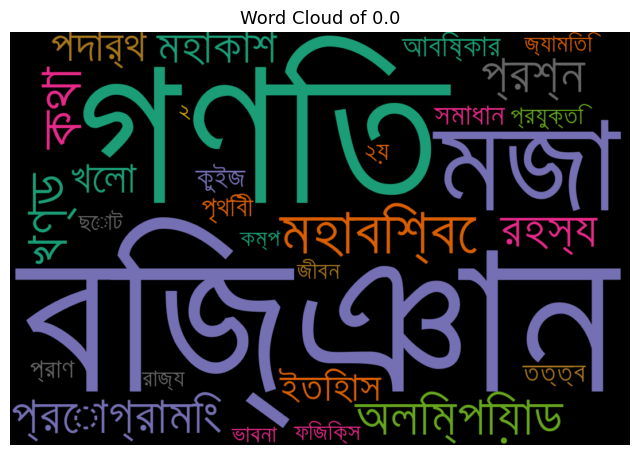

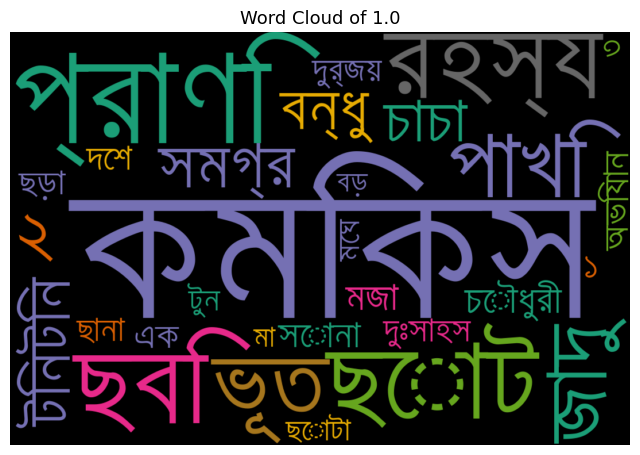

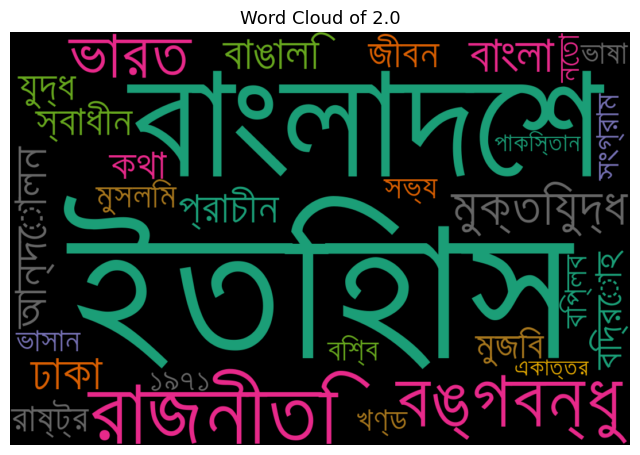

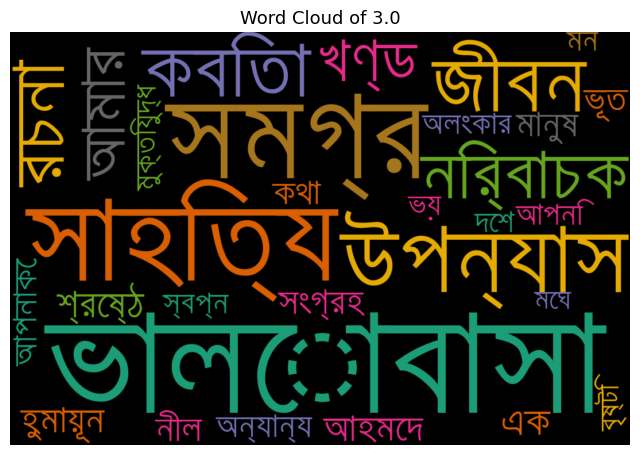

In [98]:
for i in category_list:
    temp = df.loc[df['GENRE'] == i].copy() 
    temp.loc[:, 'temp_list'] = temp['Final'].apply(lambda x: str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(30))
    temp.columns = ['Common_words', 'count']
    generate_wordcloud(temp,str(i))

In [23]:
# Split the dataset into train (70%) and temp (30%)
train1, temp1 = train_test_split(df, random_state=42, test_size=0.3)

# Split the temp dataset into test (20%) and validation (10%)
test1, val1 = train_test_split(temp1, random_state=42, test_size=0.3333)

# Initialize lists for sentences
training_sentences = []
testing_sentences = []
validation_sentences = []

# Extract sentences and labels for training set
train_sentences = train1['Final'].values
train_labels = train1['GENRE'].values
for i in range(train_sentences.shape[0]): 
    x = str(train_sentences[i])
    training_sentences.append(x)
training_sentences = np.array(training_sentences)

# Extract sentences and labels for testing set
test_sentences = test1['Final'].values
test_labels = test1['GENRE'].values
for i in range(test_sentences.shape[0]): 
    x = str(test_sentences[i])
    testing_sentences.append(x)
testing_sentences = np.array(testing_sentences)

# Extract sentences and labels for validation set
val_sentences = val1['Final'].values
val_labels = val1['GENRE'].values
for i in range(val_sentences.shape[0]): 
    x = str(val_sentences[i])
    validation_sentences.append(x)
validation_sentences = np.array(validation_sentences)

# Convert labels to categorical
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)
val_labels = keras.utils.to_categorical(val_labels)

# Print dataset shapes
print("Training Set Length: " + str(len(train1)))
print("Testing Set Length: " + str(len(test1)))
print("Validation Set Length: " + str(len(val1)))
print("training_sentences shape: " + str(training_sentences.shape))
print("testing_sentences shape: " + str(testing_sentences.shape))
print("validation_sentences shape: " + str(validation_sentences.shape))
print("train_labels shape: " + str(train_labels.shape))
print("test_labels shape: " + str(test_labels.shape))
print("val_labels shape: " + str(val_labels.shape))

Training Set Length: 3125
Testing Set Length: 893
Validation Set Length: 447
training_sentences shape: (3125,)
testing_sentences shape: (893,)
validation_sentences shape: (447,)
train_labels shape: (3125, 4)
test_labels shape: (893, 4)
val_labels shape: (447, 4)


In [24]:
vocab_size = 3200
embedding_dim = 300
max_length = 8
trunc_type='post'
oov_tok = "<OOV>"

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [26]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# over = SMOTE(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = over.fit_resample(padded, train_labels)
# under = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# X_resampled, y_resampled = under.fit_resample(padded, train_labels)

# X_resampled = np.array(X_resampled)
# y_resampled = np.array(y_resampled)




test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(validation_sentences)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

2963
Word index length:2963


In [27]:
word_index

{'<OOV>': 1,
 'গণিত': 2,
 'বিজ্ঞান': 3,
 'ইতিহাস': 4,
 'বাংলাদেশ': 5,
 'কমিকস': 6,
 'রাজনীতি': 7,
 'মজা': 8,
 'রহস্য': 9,
 'বঙ্গবন্ধু': 10,
 'জীবন': 11,
 'কথা': 12,
 'ছোট': 13,
 'খণ্ড': 14,
 'প্রাণি': 15,
 'ছবি': 16,
 'ভালোবাসা': 17,
 'সমগ্র': 18,
 'ভারত': 19,
 'বাংলা': 20,
 'ঢাকা': 21,
 'এক': 22,
 'ভূত': 23,
 'মুক্তিযুদ্ধ': 24,
 '২': 25,
 'মহাবিশ্বে': 26,
 'দেশ': 27,
 'বাঙালি': 28,
 'অলিম্পিয়াড': 29,
 'প্রশ্ন': 30,
 'পাখি': 31,
 'আমার': 32,
 'জাদু': 33,
 'সাহিত্য': 34,
 'খেলা': 35,
 'মানুষ': 36,
 'স্বাধীন': 37,
 'মহাকাশ': 38,
 'উপন্যাস': 39,
 'বিশ্ব': 40,
 'মা': 41,
 'আন্দোলন': 42,
 'প্রোগ্রামিং': 43,
 'পৃথিবী': 44,
 '১': 45,
 'যুদ্ধ': 46,
 'হওয়া': 47,
 'প্রাচীন': 48,
 'আলো': 49,
 'পদার্থ': 50,
 'শেখ': 51,
 'অন্যান্য': 52,
 '২য়': 53,
 'বিপ্লব': 54,
 'বিদ্রোহ': 55,
 'ভাষা': 56,
 'মেঘ': 57,
 'মুজিব': 58,
 'আবিষ্কার': 59,
 'সভ্য': 60,
 '৩': 61,
 'আধুনিক': 62,
 'কবিতা': 63,
 '১ম': 64,
 'প্রাণ': 65,
 'ভাবনা': 66,
 'সমাধান': 67,
 'মন': 68,
 'রাষ্ট্র': 69,
 'সেরা': 70,
 'সংগ্রাম': 71,
 'নী

In [29]:
print("Sentence :--> \n")
print(training_sentences[1]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[1])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[1])

Sentence :--> 

ভাগ্য বাদশা আমা

Sentence Tokenized and Converted into Sequence :--> 

[470, 700, 1164]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0  470  700 1164]


In [32]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    #Dropout(0.4),
    Dense(32 ,kernel_regularizer=regularizers.l2(0.01),activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# model = Sequential([
#     Embedding(vocab_size, embedding_dim, input_length=max_length),
#     Conv1D(128, 5, activation='relu'),
#     MaxPooling1D(pool_size=4),
#     LSTM(64, return_sequences=True),
#     Dropout(0.4),
#     LSTM(64),
#     Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
#     Dropout(0.4),
#     Dense(4, activation='softmax')
# ])


In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 8, 300)            960000    
                                                                 
 bidirectional (Bidirection  (None, 8, 64)             85248     
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 8, 64)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [34]:
optimizers = tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])

In [35]:
logdir='lstm'
batch = 256

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping= tf.keras.callbacks.EarlyStopping(patience= 6, restore_best_weights= True, monitor='val_loss')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


In [37]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(train_labels, axis=1)), y=np.argmax(train_labels, axis=1))
class_weights = dict(enumerate(class_weights))

print(class_weights)


{0: 0.9597665847665847, 1: 1.0119818652849741, 2: 0.8949026345933563, 3: 1.173048048048048}


In [38]:
history=model.fit(padded,train_labels,epochs=60,batch_size= batch,validation_data=(val_padded,val_labels),callbacks=[tensorboard_callback,early_stopping,lr_scheduler],class_weight=class_weights)

Epoch 1/60
13/13 [==============================] - 3s 68ms/step - loss: 1.8137 - accuracy: 0.2502 - val_loss: 1.8092 - val_accuracy: 0.2438 - lr: 1.0000e-04
Epoch 2/60
13/13 [==============================] - 0s 21ms/step - loss: 1.8050 - accuracy: 0.2682 - val_loss: 1.8012 - val_accuracy: 0.2528 - lr: 1.0000e-04
Epoch 3/60
13/13 [==============================] - 0s 23ms/step - loss: 1.7971 - accuracy: 0.2666 - val_loss: 1.7928 - val_accuracy: 0.2550 - lr: 1.0000e-04
Epoch 4/60
13/13 [==============================] - 0s 24ms/step - loss: 1.7875 - accuracy: 0.3030 - val_loss: 1.7842 - val_accuracy: 0.2886 - lr: 1.0000e-04
Epoch 5/60
13/13 [==============================] - 0s 23ms/step - loss: 1.7791 - accuracy: 0.3062 - val_loss: 1.7754 - val_accuracy: 0.3020 - lr: 1.0000e-04
Epoch 6/60
13/13 [==============================] - 0s 26ms/step - loss: 1.7690 - accuracy: 0.3315 - val_loss: 1.7659 - val_accuracy: 0.3199 - lr: 1.0000e-04
Epoch 7/60
13/13 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


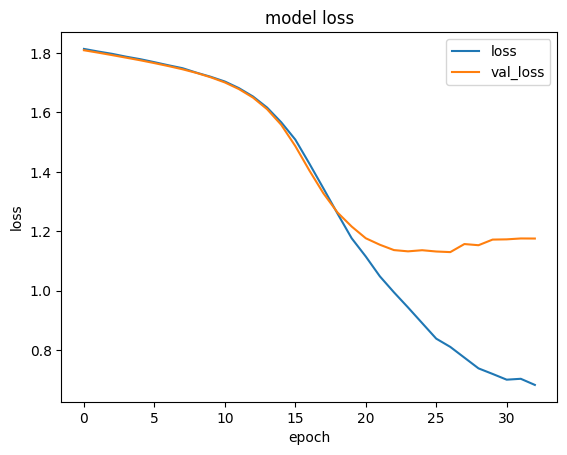

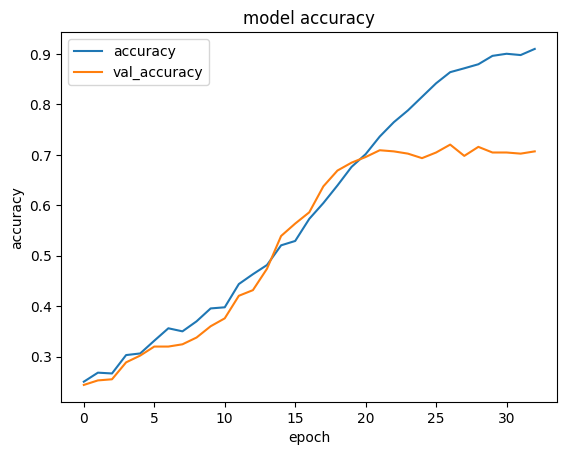

In [39]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [40]:
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=batch)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=batch)
print("The test accuracy is: "+str(loss_and_metrics[1]))

13/13 [==============================] - 0s 7ms/step - loss: 0.6636 - accuracy: 0.9328
The train accuracy is: 0.9327999949455261
4/4 [==============================] - 0s 7ms/step - loss: 1.1650 - accuracy: 0.7044
The test accuracy is: 0.7043672800064087


In [41]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_true, y_pred, target_names=target_names))

28/28 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

     class 0       0.88      0.77      0.82       230
     class 1       0.59      0.61      0.60       223
     class 2       0.82      0.81      0.81       244
     class 3       0.54      0.60      0.57       196

    accuracy                           0.70       893
   macro avg       0.71      0.70      0.70       893
weighted avg       0.72      0.70      0.71       893



28/28 [==============================] - 0s 2ms/step


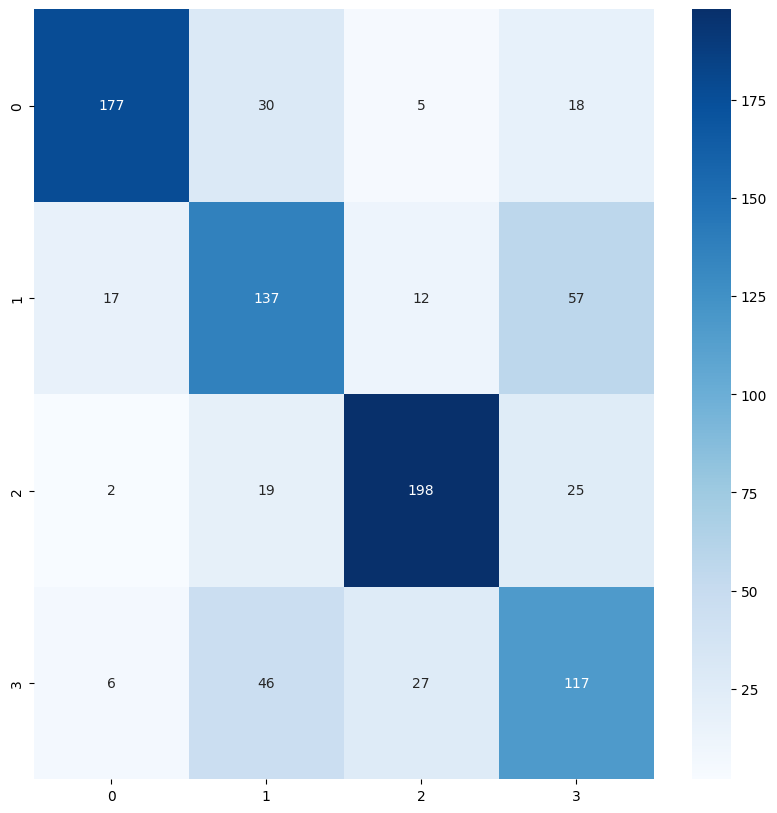

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(testing_padded)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_labels, axis=1)
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()